## Load Python Libraries

In [125]:
import torch
from torchvision import transforms
import torchvision.models as models
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from scipy.stats import pearsonr
from PIL import Image

## Defining the model

In [126]:
# Define model
class Linear_NN(torch.nn.Module):

    # 180 is given from the one-hot encoding of the 20 amino acids * 9 peptide length
    def __init__(self, input_size):
        super(Linear_NN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, input_size // 2)
        self.fc2 = torch.nn.Linear(input_size//2, input_size // 10)
        self.fc3 = torch.nn.Linear(input_size//10, 1)
        self.drop = torch.nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.drop(x)
        out = self.fc3(x)
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Get a list of peptides

In [127]:
peptide_score_file = './data/training_peptide_PSSM_scores.txt'

def load_peptide_data(infile):

    peptides = list()
    PSSM_score = list()

    with open(infile) as f:
        for line in f:
            peptide, score = line.strip().split()
            peptides.append(list(peptide))
            PSSM_score.append(float(score))

    return peptides, PSSM_score

peptides, PSSM_score = load_peptide_data(peptide_score_file)

## One-hot encoding of the pepetides

In [128]:
def one_hot_encode_peptides(peptides):

    flattened_peptides = np.array(peptides).flatten().reshape(-1, 1)

    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(categories=[list('ACDEFGHIKLMNPQRSTVWY')], sparse_output=False)

    # Transform the peptide sequences into a one-hot encoded format
    one_hot_encoded = encoder.fit_transform(flattened_peptides)

    # Reshape back into the original peptide sequence format
    num_peptides = len(peptides)
    one_hot_encoded_peptides = one_hot_encoded.reshape(num_peptides, -1)

    return one_hot_encoded_peptides

## PCA-reduced Pixel encoding

In [129]:
amino_acid_full_names = {
    'A': 'alanine', 'R': 'arginine', 'N': 'asparagine', 'D': 'aspartic_acid', 'C': 'cysteine', 
    'E': 'glutamic_acid', 'Q': 'glutamine', 'G': 'glycine', 'H': 'histidine', 'I': 'isoleucine', 
    'L': 'leucine', 'K': 'lysine', 'M': 'methionine', 'F': 'phenylalanine', 'P': 'proline',
    'S': 'serine', 'T': 'threonine', 'W': 'tryptophan', 'Y': 'tyrosine', 'V': 'valine'
}

### Load amino acid depictions

In [130]:
#store images in cache to save performance
image_cache = {}

def load_AA_image(img_path):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image

## PCA pixel feature extraction

In [131]:
def PCA_pixel_features(amino_acid_full_names):
    
    pixel_features = []

    for letter, aa in amino_acid_full_names.items():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path)
        pixel_features.append(image.flatten())

    pixel_features = np.vstack(pixel_features)

    # PCA
    pca = PCA(random_state=42)
    pca_pixel_features = pca.fit_transform(pixel_features)

    # Create dictionary with aa_name:PCA_feature
    aa_features_dict = {}
    for idx, aa in enumerate(amino_acid_full_names.keys()):
        aa_features_dict[aa] = pca_pixel_features[idx, :]

    return aa_features_dict, pca

In [132]:
def plot_PCA_variance(pca, encoding_method, cumulative=True):
    # Assuming you have already performed PCA and stored it in the variable 'pca'
    variance_ratio = pca.explained_variance_ratio_

    if cumulative:
        cumulative_variance = np.cumsum(variance_ratio)
        plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, '*-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Variance')
        plt.title('Cumulative Variance by Number of Components, Encoding Method: ' + encoding_method)
        plt.show()
    else:
        plt.bar(range(1, len(variance_ratio)+1), variance_ratio)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance Ratio')
        plt.title('Variance Ratio by Number of Components, Encoding Method: ' + encoding_method)
        plt.show()
    

## VGG16 transformation

In [133]:
def vgg_features(amino_acid_full_names):

    # Define VGG model
    vgg16_bn = torch.nn.Sequential(   
    # Use only the convolutionary part
    models.vgg16_bn(pretrained = True).features,
    torch.nn.Flatten()
    )

    vgg16 = vgg16_bn.to(device)
    vgg16.eval()

    vgg_features = []

    for aa in amino_acid_full_names.values():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path)

        # Disable gradient calculation
        with torch.no_grad():
            conv_features = vgg16(image)

        vgg_features.append(conv_features.cpu().numpy())

    vgg_features = np.vstack(vgg_features)

    pca = PCA(random_state=42)
    pca_vgg_features = pca.fit_transform(vgg_features)

    # Create dictionary with aa_name:PCA_feature
    aa_features_dict = {}
    for idx, aa in enumerate(amino_acid_full_names.keys()):
        aa_features_dict[aa] = pca_vgg_features[idx, :]

    return aa_features_dict, pca

## Peptide data encoding

In [134]:
def Encoder(peptides, aa_features_dict):
    
    encoded_peptides = []

    for peptide in peptides:
        encoded_peptide = []
    
        for aa in peptide:
            encoded_peptide.append(aa_features_dict[aa])
        
        encoded_peptide = np.array(encoded_peptide).flatten()
        encoded_peptides.append(encoded_peptide)

    return np.array(encoded_peptides)

C:\Users\Chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


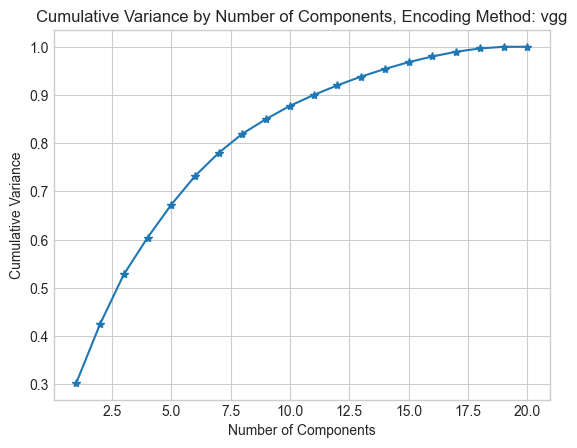

In [135]:
encoding_method = 'vgg'

if encoding_method == 'onehot':
    encoded_peptides = one_hot_encode_peptides(peptides)

elif encoding_method == 'pca':
    
    aa_feature_dict, pca = PCA_pixel_features(amino_acid_full_names)
    plot_PCA_variance(pca, encoding_method, cumulative=True)
    encoded_peptides = Encoder(peptides, aa_feature_dict)

elif encoding_method == 'vgg':
    aa_feature_dict, pca = vgg_features(amino_acid_full_names)
    plot_PCA_variance(pca, encoding_method, cumulative=True)
    encoded_peptides = Encoder(peptides, aa_feature_dict)

else:
    raise ValueError('Invalid encoding method')


input_size = encoded_peptides[0].shape[0]

## Define function to reset weight
Weight resetting aid to prevent the weight leakage

In [112]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        print(f'reset weight of layer {m}')
        m.reset_parameters()

### Loss function and optimizer

In [113]:
# Define the loss function 
criterion = torch.nn.MSELoss()

In [114]:
peptides_tensor = torch.tensor(encoded_peptides, dtype=torch.float32).to(device)
PSSM_score_tensor = torch.tensor(np.asarray(PSSM_score).reshape(-1,1), dtype=torch.float32).to(device)

peptides_dataset = TensorDataset(peptides_tensor, PSSM_score_tensor)

## Train model

In [115]:
def plot_loss(train_loss, val_loss, fold, encoding_method):
    plt.figure()
    plt.plot(train_loss, label='train err')
    plt.plot(val_loss, label='val err')
    plt.legend()
    plt.yscale('log')
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'./loss/{encoding_method}_loss_fold_{fold}.png')
    plt.close()

In [116]:
torch.manual_seed(69)

kfold = KFold(n_splits=5, shuffle=True)

print("Starting KFold Cross Validation")

for fold, (train_ids, test_ids) in enumerate(kfold.split(peptides_dataset), 1):
    
    print(f'Fold {fold}')

    # Shuffle the data
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # Define the data loaders
    train_loader = DataLoader(peptides_dataset, batch_size=10, sampler=train_subsampler)
    test_loader = DataLoader(peptides_dataset, batch_size=10, sampler=test_subsampler)

    # Initialize NN
    model = Linear_NN(input_size).to(device)
    model.apply(reset_weights)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    training_losses = []
    validation_losses = []

    for epoch in range(0, 100):
    
            print(f'Epoch {epoch+1}')

            training_loss = 0.0

            for i, data in enumerate(train_loader):
                  
                # Get the inputs
                inputs, labels = data

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs.view(-1, 180))

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Backward pass
                loss.backward()

                # Optimize
                optimizer.step()

                training_loss += loss.item()
            
            with torch.no_grad():
                model.eval()
                validation_loss = 0.0

                for inputs, labels in test_loader:

                    outputs = model(inputs.view(-1, 180))
                    loss = criterion(outputs, labels)

                    validation_loss += loss.item()

            training_losses.append(training_loss/len(train_loader))
            validation_losses.append(validation_loss/len(test_loader))

            print(f'Training loss: {training_loss/len(train_loader)}')
            print(f'Validation Loss: {validation_loss/len(test_loader)}')

            
    # Save the model
    print('Finished Training, Saving Model')
    torch.save(model.state_dict(), f'./model/{encoding_method}_model_fold_{fold}.pt')

    # Plot the loss
    plot_loss(training_losses, validation_losses, fold, encoding_method) 
  
    

Starting KFold Cross Validation
Fold 1
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=18, bias=True)
reset weight of layer Linear(in_features=18, out_features=1, bias=True)
Epoch 1
Training loss: 12.623691149593629
Validation Loss: 3.045450282096863
Epoch 2
Training loss: 1.368449781051616
Validation Loss: 1.1457247591018678
Epoch 3
Training loss: 0.3941183955091791
Validation Loss: 0.8649996423721313
Epoch 4
Training loss: 0.19371533155748524
Validation Loss: 0.6944957256317139
Epoch 5
Training loss: 0.10909141012534652
Validation Loss: 0.5829990756511688
Epoch 6
Training loss: 0.065591298485386
Validation Loss: 0.5473188042640686
Epoch 7
Training loss: 0.03716597286504261
Validation Loss: 0.5146776050329208
Epoch 8
Training loss: 0.025360239856905237
Validation Loss: 0.4925218829512596
Epoch 9
Training loss: 0.017210209319732852
Validation Loss: 0.5057213914394378
Epoch 10
Training loss: 0.0115996572

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11212\2227277579.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 2
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=18, bias=True)
reset weight of layer Linear(in_features=18, out_features=1, bias=True)
Epoch 1
Training loss: 12.31492657759755
Validation Loss: 4.326747522354126
Epoch 2
Training loss: 1.550626765821398
Validation Loss: 1.2449147701263428
Epoch 3
Training loss: 0.40390430459963905
Validation Loss: 0.792051522731781
Epoch 4
Training loss: 0.1811646825259494
Validation Loss: 0.6541977781057358
Epoch 5
Training loss: 0.1010208871292392
Validation Loss: 0.5282176458835601
Epoch 6
Training loss: 0.057075789467114765
Validation Loss: 0.5141733703017235
Epoch 7
Training loss: 0.03503898592646589
Validation Loss: 0.5060585749149322
Epoch 8
Training loss: 0.022999772710783274
Validation Loss: 0.4784968012571335
Epoch 9
Training loss: 0.015502867636933308
Validation Loss: 0.4729478394985199
Epoch 10
Training loss: 0.01019204137174739
Validation Loss: 0.49704

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11212\2227277579.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 3
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=18, bias=True)
reset weight of layer Linear(in_features=18, out_features=1, bias=True)
Epoch 1
Training loss: 13.27873855276206
Validation Loss: 2.6078534650802614
Epoch 2
Training loss: 1.4416162178073961
Validation Loss: 0.7157257503271103
Epoch 3
Training loss: 0.39951487922484114
Validation Loss: 0.42347290813922883
Epoch 4
Training loss: 0.1751740590198753
Validation Loss: 0.35980006396770475
Epoch 5
Training loss: 0.09726423293966607
Validation Loss: 0.32925349473953247
Epoch 6
Training loss: 0.05771644966504008
Validation Loss: 0.2792565593123436
Epoch 7
Training loss: 0.034636042762509325
Validation Loss: 0.28739027231931685
Epoch 8
Training loss: 0.024120378240789334
Validation Loss: 0.2675611326098442
Epoch 9
Training loss: 0.01453208120194139
Validation Loss: 0.26382085025310514
Epoch 10
Training loss: 0.010117671106817182
Validation Loss

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11212\2227277579.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 4
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=18, bias=True)
reset weight of layer Linear(in_features=18, out_features=1, bias=True)
Epoch 1
Training loss: 12.542778907362948
Validation Loss: 3.0206899666786193
Epoch 2
Training loss: 1.2908640195106722
Validation Loss: 0.9323251870274544
Epoch 3
Training loss: 0.37754920509058176
Validation Loss: 0.6173155546188355
Epoch 4
Training loss: 0.1652043145726022
Validation Loss: 0.48071116626262667
Epoch 5
Training loss: 0.08653396018540736
Validation Loss: 0.4897170841693878
Epoch 6
Training loss: 0.04849064438459799
Validation Loss: 0.4423408555984497
Epoch 7
Training loss: 0.0308176109509677
Validation Loss: 0.4136221469193697
Epoch 8
Training loss: 0.020573077910608546
Validation Loss: 0.39729434579610823
Epoch 9
Training loss: 0.014036305524773666
Validation Loss: 0.38882040172815324
Epoch 10
Training loss: 0.009528766919081052
Validation Loss: 

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11212\2227277579.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fold 5
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=18, bias=True)
reset weight of layer Linear(in_features=18, out_features=1, bias=True)
Epoch 1
Training loss: 13.196272397778698
Validation Loss: 2.972978776693344
Epoch 2
Training loss: 1.2685177038932585
Validation Loss: 0.9566165268421173
Epoch 3
Training loss: 0.36305491142358975
Validation Loss: 0.5993377476930618
Epoch 4
Training loss: 0.17434976906659677
Validation Loss: 0.48157746613025665
Epoch 5
Training loss: 0.09104783397129516
Validation Loss: 0.44493409126996997
Epoch 6
Training loss: 0.050997927516084354
Validation Loss: 0.3997477641166188
Epoch 7
Training loss: 0.03136498225641619
Validation Loss: 0.3881084328144789
Epoch 8
Training loss: 0.01911394666285091
Validation Loss: 0.37166571855545044
Epoch 9
Training loss: 0.013068113836085367
Validation Loss: 0.3652212333679199
Epoch 10
Training loss: 0.009984548878135909
Validation Loss:

C:\Users\Chuan\AppData\Local\Temp\ipykernel_11212\2227277579.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Evaluating the model with unseen data

In [117]:
evaluation_data = './data/evaluation_peptide_PSSM_scores.txt'
# evaluation_data = '../data/data/PSSM/A0201.eval'
evaluation_peptides, evaluation_score = load_peptide_data(evaluation_data)

if encoding_method == 'onehot':
    encoded_evaluation_peptides = one_hot_encode_peptides(evaluation_peptides)
else:
    encoded_evaluation_peptides = Encoder(evaluation_peptides, aa_feature_dict)

# Convert to tensors
evaluation_peptides_tensor = torch.tensor(encoded_evaluation_peptides, dtype=torch.float32).to(device)
evaluation_score_tensor = torch.tensor(np.asarray(evaluation_score).reshape(-1,1), dtype=torch.float32).to(device)

evaluation_peptides_dataset = TensorDataset(evaluation_peptides_tensor, evaluation_score_tensor)


def evaluate_model(models, evaluation_peptides_dataset):
    predictions = []

    evaluation_data_loader = DataLoader(evaluation_peptides_dataset, batch_size=10)

    with torch.no_grad():
        for model in models:
            model.eval()
            model_predictions = []

            for peptides, _ in evaluation_data_loader:
                peptides = peptides.to(device)
                outputs = model(peptides.view(-1, 180))
                model_predictions.extend(outputs.cpu().numpy())

            predictions.append(model_predictions)

    # Average predictions across models
    averaged_predictions = np.mean(predictions, axis=0)

    # Calculate total loss
    total_loss = criterion(torch.tensor(averaged_predictions, dtype=torch.float32).to(device), evaluation_score_tensor).item()

    return averaged_predictions, total_loss

# Load models
models = []
for i in range(1,6):
    model = Linear_NN(input_size).to(device)
    model.load_state_dict(torch.load(f'./model/{encoding_method}_model_fold_{i}.pt'))
    models.append(model)

# Test models
predictions, total_loss = evaluate_model(models, evaluation_peptides_dataset)

print(f'Total Loss: {total_loss}')

Total Loss: 0.17562580108642578


## Saving evaluation data prediction result

In [118]:
outfile = f'./evaluation_result/{encoding_method}_evaluation_predictions.txt'

with open(outfile, 'w') as f:
    print('Peptide      Score      Prediction', file=f)
    for peptide, score, prediction in zip(evaluation_peptides, evaluation_score, predictions):
        print(f'{"".join(peptide):<12} {score:<10.4f} {prediction[0]:<10.4f}', file=f)

PCC:  0.996140626707293


C:\Users\Chuan\AppData\Local\Temp\ipykernel_11212\2539975301.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid');


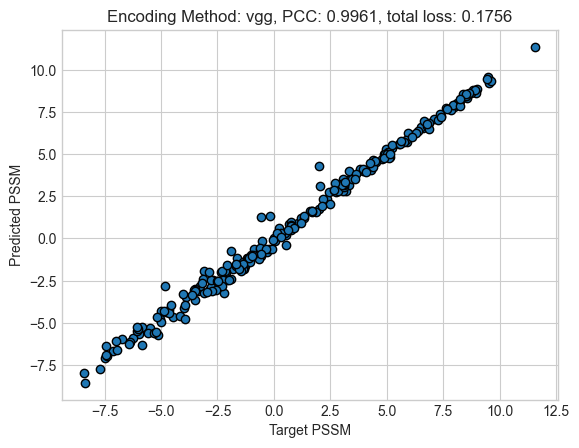

In [119]:
pcc = pearsonr(evaluation_score, np.array(predictions).flatten())
print("PCC: ", pcc[0])

plt.figure()
plt.style.use('seaborn-whitegrid');
plt.scatter(evaluation_score, predictions, edgecolors='black');
plt.xlabel('Target PSSM');
plt.ylabel('Predicted PSSM');
plt.title(f'Encoding Method: {encoding_method}, PCC: {pcc[0]:.4f}, total loss: {total_loss:.4f}');
plt.savefig(f'./evaluation_result/{encoding_method}_evaluation_scatter.png')